In [304]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import nilearn

from nilearn.datasets import fetch_haxby
from nilearn import input_data, plotting, image
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.plotting.img_plotting import plot_epi, plot_roi
import nibabel as nib

In [170]:
warnings.filterwarnings('ignore')

## Haxby datset

Во время эксперимента испытуемым показывали различные изображения. Категории изображений представляются в метках, а именно каждая метка соответствует определенной категории изображений. Например, если в эксперименте использовались изображения различных объектов, метки могут обозначать какие-то определенные объекты. Таким образом, задача классификации заключается в том, чтобы по фМРТ-снимкам предсказать, какой класс картинок наблюдал испытуемый.

Классы:
- bottle
- cat
- chair
- face
- house
- scissors
- scrambledpix
- shoe
Также присутствует rest, когда испытуемому ничего не показывали

In [291]:
class haxby_dataset():
    def __init__(self):
        path = '\data_fmri'
        self.data_files = fetch_haxby(data_dir=path, subjects=(1, 2, 3, 4, 5, 6), fetch_stimuli=True, url=None, resume=True, verbose=1)


    def get_sub_data(self, num):
        # пути к данным
        fmri_data = self.data_files['func'][num-1]  # фМРТ-снимки
        labels = self.data_files['session_target'][num-1] # метки классов

        fmri_img = nib.load(fmri_data)
        fmri_array = fmri_img.get_fdata()
        labels_frame = pd.read_csv(labels, delimiter=' ')
        return fmri_array, labels_frame
    

    def plot_stimuli(self):
        stimulus_information = self.data_files.stimuli

        for stim_type in stimulus_information:
            # skip control images, there are too many
            if stim_type != 'controls':

                file_names = stimulus_information[stim_type]
                file_names = file_names[0:16]
                fig, axes = plt.subplots(4, 4)
                fig.suptitle(stim_type)

                for img_path, ax in zip(file_names, axes.ravel()):
                    ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

                for ax in axes.ravel():
                    ax.axis("off")
        plt.show()


In [292]:
dataset = haxby_dataset()
datafiles = dataset.data_files

In [301]:
# Описание датасета
#print(datafiles['description'])

In [293]:
# отрисовка стимулов 
#dataset.plot_stimuli()

Получим данные первого испытуемого

In [294]:
fmris, labels = dataset.get_sub_data(1)

In [235]:
fmris.shape

(40, 64, 64, 1452)

In [175]:
labels.head()

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


---

### Маски активности

The ventral temporal cortex. Эта маска была создана в рамках исследования Haxby(2001) и выделяет часть мозга, специализирующуюся на обработке визуальной информации, и которая содержит области, чувствительные к различным типам категорий изображений. Далее проводим анализ для первого испытуемого

In [195]:
vt_mask_filename = load_img(datafiles.mask_vt[0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

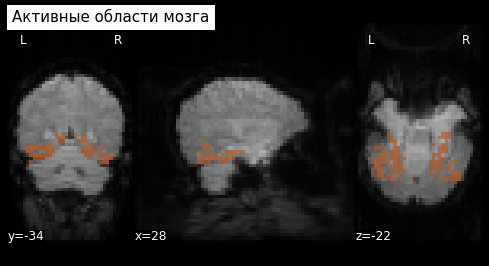

In [223]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=False, 
                  cmap='Paired')

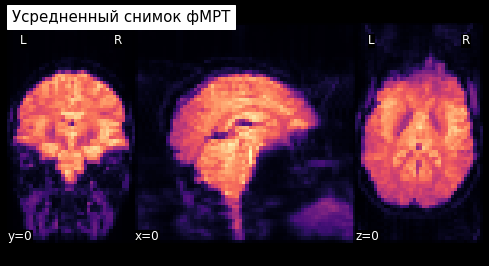

In [221]:
plot_epi(mean_haxby, cut_coords=(0, 0, 0), cmap='magma', title = 'Усредненный снимок фМРТ')

In [197]:
# Применение маски активации к фмрт снимкам
masker = input_data.NiftiMasker(mask_img=vt_mask_filename, standardize=True)
fmri_masked = masker.fit_transform(func_filename)

In [153]:
fmri_masked.shape

(1452, 577)

---

### Подготовка данных
Данные первого испытуемого хранятся в переменных fmris, labels, разделим последовательность на временные ряды по классам

In [250]:
# Определение классов и их индексов
unique_classes = np.unique(labels['labels'].values)

# Создание словаря, в котором ключами будут классы, а значениями будут соответствующие им временные ряды
class_data = {cls: [] for cls in unique_classes}

current_class = labels['labels'].values[0]
current_sequence = [fmris[:,:,:,0]]

# Итерация по данным и создание временных рядов для каждого класса
for i in range(1, len(labels)):
    if labels['labels'].values[i] == current_class:
        current_sequence.append(fmris[:,:,:,i])
    else:
        class_data[current_class].append(np.array(current_sequence))
        current_class = labels['labels'].values[i]
        current_sequence = [fmris[:,:,:,i]]

# Добавление последней последовательности
class_data[current_class].append(np.array(current_sequence))

In [272]:
unique_classes 

array(['bottle', 'cat', 'chair', 'face', 'house', 'rest', 'scissors',
       'scrambledpix', 'shoe'], dtype=object)

In [288]:
len(class_data['chair'])

12

In [290]:
class_data['chair'][11].shape

(9, 40, 64, 64)

---

nilearn.datasets.fetch_abide_pcp 

датасет про классификацию болезней, вроде бы 17 года.


Коллекция данных по функциональной магнитно-резонансной томографии (fMRI), созданная для исследования различий в мозговой активности у людей с аутизмом. Датасет включает в себя данные от нескольких исследовательских центров и объединяет информацию о мозговой активности у лиц с аутизмом и соответствующих контрольных группах.

Вот некоторые основные характеристики ABIDE датасета:

- Количество испытуемых: Датасет включает данные от более чем 1000 участников, включая тех, кто имеет аутизм (ASD), и контрольную группу (TC).

- Изображения мозга: В датасете представлены структурные и функциональные изображения мозга, полученные с использованием магнитно-резонансной томографии (MRI).

- Клинические данные: Кроме изображений мозга, в датасете также содержатся клинические и демографические данные, такие как возраст, пол, диагноз и т.д.

- Многоцентровость: Данные поступают из различных медицинских центров, что обеспечивает разнообразие данных и их репрезентативность.

---
## Dataset

In [307]:
path = '\data_fmri_motor_task_dataset'
# Загрузка датасета 'ds000157' из OpenNeuro
motor_task_dataset = nilearn.datasets.fetch_openneuro_dataset(data_dir=path, dataset_version='ds000157', verbose=1)

# Получение информации о датасете
print(motor_task_dataset.description)


Added README.md to \data_fmri_motor_task_dataset


Dataset created in \data_fmri_motor_task_dataset\ds000030/ds000030_R1.0.4/uncompressed



Downloaded 57098240 of 58172802 bytes (98.2%,    0.5s remaining) ...done. (35 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 14311424 of 15055201 bytes (95.1%,    0.4s remaining) ...done. (8 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 1998848 of 2593699 bytes (77.1%,    0.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 2195456 of 2794836 bytes (78.6%,    0.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 1032192 of 2586189 bytes (39.9%,    1.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 950272 of 2788694 bytes (34.1%,    2.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 2129920 of 2590285 bytes (82.2%,    0.4s remaining) ...done. (3 seconds, 0 min)


Downloaded 1081344 of 2793106 bytes (38.7%,    1.6s remaining) ...done. (3 seconds, 0 min)


Downloaded 40353792 of 40628750 bytes (99.3%,    0.2s remaining) ...done. (35 seconds, 0 min)


Downloaded 1777664 of 2581722 bytes (68.9%,    0.9s remaining) ...done. (3 seconds, 0 min)


Downloaded 1703936 of 2783579 bytes (61.2%,    1.3s remaining) ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 6881280 of 7247027 bytes (95.0%,    0.3s remaining) ...done. (7 seconds, 0 min)


Downloaded 6127616 of 7392069 bytes (82.9%,    0.8s remaining) ...done. (6 seconds, 0 min)


Downloaded 6619136 of 7447835 bytes (88.9%,    0.9s remaining) ...done. (9 seconds, 0 min)


Downloaded 7397376 of 8309334 bytes (89.0%,    0.7s remaining) ...done. (7 seconds, 0 min)


Downloaded 101523456 of 102374780 bytes (99.2%,    0.8s remaining) ...done. (96 seconds, 1 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 175112192 of 176010345 bytes (99.5%,    0.8s remaining) ...done. (155 seconds, 2 min)


 ...done. (1 seconds, 0 min)


Downloaded 130318336 of 131200628 bytes (99.3%,    0.8s remaining) ...done. (115 seconds, 1 min)


Downloaded 11231232 of 11686170 bytes (96.1%,    0.3s remaining) ...done. (9 seconds, 0 min)


Downloaded 11173888 of 11720675 bytes (95.3%,    0.3s remaining) ...done. (6 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 99909632 of 100027401 bytes (99.9%,    0.1s remaining) ...done. (81 seconds, 1 min)


 ...done. (1 seconds, 0 min)


Downloaded 40230912 of 74935709 bytes (53.7%,   27.1s remaining)

KeyboardInterrupt: 